In [1]:
import os
import numpy as np
import pandas as pd
from scipy.misc import derivative
import scipy.integrate as intg
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
%matplotlib inline

from sklearn.metrics import mean_squared_error

import torch
import gpytorch

In [2]:
data_folder = 'Data_SNIa_LSST/'
dfp = pd.read_csv(data_folder+'hubble_diagram_Pr.txt', skiprows=4, sep=' ')
dfs = pd.read_csv(data_folder+'hubble_diagram_Sr.txt', skiprows=4, sep=' ')
Np = len(dfp.values)
Ns= len(dfs.values)
dfp.head()

,zCMB,zHEL,MU,MUERR,MUERR_SYS
0,0.04131,0.04131,36.31666,0.00969,0.00674
1,0.06876,0.06876,37.44798,0.00541,0.00627
2,0.13121,0.13121,38.94492,0.01969,0.00868
3,0.18499,0.18499,39.75545,0.01338,0.00658
4,0.24503,0.24503,40.42469,0.01068,0.00590


In [3]:
dfp['errors'] = dfp['MUERR_SYS'].values+dfp['MUERR_SYS'].values
dfp.head()

,zCMB,zHEL,MU,MUERR,MUERR_SYS,errors
0,0.04131,0.04131,36.31666,0.00969,0.00674,0.01348
1,0.06876,0.06876,37.44798,0.00541,0.00627,0.01254
2,0.13121,0.13121,38.94492,0.01969,0.00868,0.01736
3,0.18499,0.18499,39.75545,0.01338,0.00658,0.01316
4,0.24503,0.24503,40.42469,0.01068,0.00590,0.01180


In [4]:
df_data = dfp[['zCMB', 'MU', 'errors']]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


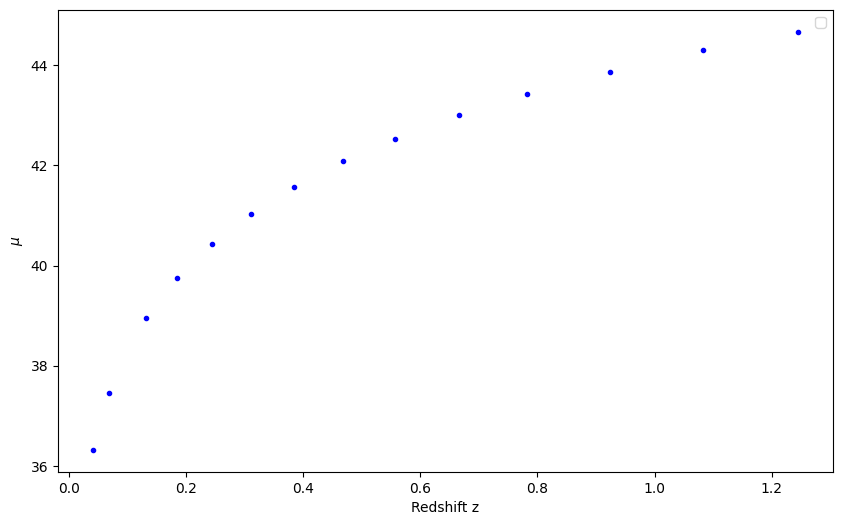

In [5]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(df_data['zCMB'].values, df_data['MU'].values, yerr=df_data['errors'].values, fmt='.', color='b', elinewidth=1, ecolor='red')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.legend()

In [6]:
# noise1x = 0.005*np.random.rand(len(dfp))
# noise1y = np.zeros((14, 2))
# noise1y[:,0] = noise1x * 2
# noise1y[:,1] = noise1x * 0.1

# noise2x = 0.005*np.random.rand(len(dfp))
# noise2y = np.zeros((14, 2))
# noise2y[:,0] = noise2x * 2
# noise2y[:,1] = noise2x * 0.1

In [7]:
z = df_data.values[:,0]
y = df_data.values[:,1:]

# z = np.append(z_or, z_or+noise1x)
# z = np.append(z, z_or+noise2x)

# y = np.append(y_or, y_or+noise1y, axis=0)
# y = np.append(y, y_or+noise2y, axis=0)

In [8]:
# scalerz = StandardScaler()
# scalerz.fit(z_or.reshape(-1,1))
# # apply transform
# z_sc = scalerz.transform(z.reshape(-1,1))
# np.shape(z_sc)

In [9]:
# split = 0.9
# ntrain = int(split * len(z))

# # randomize = np.random.permutation(len(z))
# # z = z_or[randomize]
# # y = y[randomize]

# indx = [ntrain]
# z_train, z_test = np.split(z_or, indx)
# y_train, y_test = np.split(y, indx)
# np.shape(z_train), np.shape(z_test), np.shape(y_train), np.shape(y_test)

In [10]:
# yy_train = np.append(y_train, np.array([y_or[0], y_or[-1]]), axis=0)
# zz_train = np.append(z_train, np.array([z_sc[0], z_sc[-1]]))
# np.shape(zz_train), np.shape(yy_train)

In [11]:
zmin, zmax = np.min(z), np.max(z)
zmin, zmax

(0.04131, 1.24447)

In [12]:
# split = 0.8
# ntrain = int(split * len(z))
# indx = [ntrain]
# z_train, z_test = np.split(z, indx)
# y_train, y_test = np.split(y, indx)

In [13]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 1.3, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

In [14]:
# yy = y[:,0].reshape(-1,1)
# zz = z
# split = 0.8
# ntrain = int(split * len(zz))
# indx = [ntrain]
# zz_train, zz_test = np.split(zz, indx)
# yy_train, yy_test = np.split(yy, indx)
# yy_train = np.append(yy_train, np.array([y[0], y[-1]]))
# zz_train = np.append(zz_train, np.array([z[0], z[-1]]))
np.shape(z), np.shape(y), np.shape(z), np.shape(y)

((14,), (14, 2), (14,), (14, 2))

In [15]:
# x_train = torch.tensor(z_train).reshape(len(z_train),)
# y_train = torch.tensor(y_train)

z_torch = torch.from_numpy(z).float()
y_torch = torch.from_numpy(y).float()

In [16]:
len(z)

14

In [17]:
np.shape(z), np.shape(y)

((14,), (14, 2))

In [18]:
# Definir el modelo de proceso gaussiano
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(z_torch, y_torch, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
#             gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
            gpytorch.kernels.MaternKernel(nu=1.5, lengthscale=2), num_tasks=2, rank=1
#             gpytorch.kernels.SpectralMixtureKernel(num_mixtures=2), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(z_torch, y_torch, likelihood)

In [19]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 1000
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(z_torch)
    loss = -mll(output, y_torch)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/1000 - Loss: 30.169
Iter 2/1000 - Loss: 27.869
Iter 3/1000 - Loss: 25.731
Iter 4/1000 - Loss: 23.753
Iter 5/1000 - Loss: 21.935
Iter 6/1000 - Loss: 20.273
Iter 7/1000 - Loss: 18.761
Iter 8/1000 - Loss: 17.394
Iter 9/1000 - Loss: 16.164
Iter 10/1000 - Loss: 15.062
Iter 11/1000 - Loss: 14.079
Iter 12/1000 - Loss: 13.204
Iter 13/1000 - Loss: 12.429
Iter 14/1000 - Loss: 11.742
Iter 15/1000 - Loss: 11.134
Iter 16/1000 - Loss: 10.596
Iter 17/1000 - Loss: 10.120
Iter 18/1000 - Loss: 9.698
Iter 19/1000 - Loss: 9.323
Iter 20/1000 - Loss: 8.988
Iter 21/1000 - Loss: 8.688
Iter 22/1000 - Loss: 8.418
Iter 23/1000 - Loss: 8.174
Iter 24/1000 - Loss: 7.952
Iter 25/1000 - Loss: 7.749
Iter 26/1000 - Loss: 7.563
Iter 27/1000 - Loss: 7.391
Iter 28/1000 - Loss: 7.230
Iter 29/1000 - Loss: 7.081
Iter 30/1000 - Loss: 6.940
Iter 31/1000 - Loss: 6.808
Iter 32/1000 - Loss: 6.682
Iter 33/1000 - Loss: 6.564
Iter 34/1000 - Loss: 6.450
Iter 35/1000 - Loss: 6.342
Iter 36/1000 - Loss: 6.239
Iter 37/1000 - Loss:

Iter 305/1000 - Loss: 0.595
Iter 306/1000 - Loss: 0.588
Iter 307/1000 - Loss: 0.580
Iter 308/1000 - Loss: 0.573
Iter 309/1000 - Loss: 0.565
Iter 310/1000 - Loss: 0.558
Iter 311/1000 - Loss: 0.551
Iter 312/1000 - Loss: 0.544
Iter 313/1000 - Loss: 0.537
Iter 314/1000 - Loss: 0.529
Iter 315/1000 - Loss: 0.522
Iter 316/1000 - Loss: 0.515
Iter 317/1000 - Loss: 0.508
Iter 318/1000 - Loss: 0.501
Iter 319/1000 - Loss: 0.494
Iter 320/1000 - Loss: 0.488
Iter 321/1000 - Loss: 0.481
Iter 322/1000 - Loss: 0.474
Iter 323/1000 - Loss: 0.467
Iter 324/1000 - Loss: 0.460
Iter 325/1000 - Loss: 0.454
Iter 326/1000 - Loss: 0.447
Iter 327/1000 - Loss: 0.441
Iter 328/1000 - Loss: 0.434
Iter 329/1000 - Loss: 0.427
Iter 330/1000 - Loss: 0.421
Iter 331/1000 - Loss: 0.414
Iter 332/1000 - Loss: 0.408
Iter 333/1000 - Loss: 0.402
Iter 334/1000 - Loss: 0.395
Iter 335/1000 - Loss: 0.389
Iter 336/1000 - Loss: 0.383
Iter 337/1000 - Loss: 0.376
Iter 338/1000 - Loss: 0.370
Iter 339/1000 - Loss: 0.364
Iter 340/1000 - Loss

Iter 610/1000 - Loss: -0.562
Iter 611/1000 - Loss: -0.564
Iter 612/1000 - Loss: -0.565
Iter 613/1000 - Loss: -0.567
Iter 614/1000 - Loss: -0.569
Iter 615/1000 - Loss: -0.571
Iter 616/1000 - Loss: -0.572
Iter 617/1000 - Loss: -0.574
Iter 618/1000 - Loss: -0.576
Iter 619/1000 - Loss: -0.577
Iter 620/1000 - Loss: -0.579
Iter 621/1000 - Loss: -0.581
Iter 622/1000 - Loss: -0.582
Iter 623/1000 - Loss: -0.584
Iter 624/1000 - Loss: -0.585
Iter 625/1000 - Loss: -0.587
Iter 626/1000 - Loss: -0.588
Iter 627/1000 - Loss: -0.584
Iter 628/1000 - Loss: -0.554
Iter 629/1000 - Loss: -0.453
Iter 630/1000 - Loss: -0.453
Iter 631/1000 - Loss: -0.594
Iter 632/1000 - Loss: -0.507
Iter 633/1000 - Loss: -0.547
Iter 634/1000 - Loss: -0.580
Iter 635/1000 - Loss: -0.528
Iter 636/1000 - Loss: -0.601
Iter 637/1000 - Loss: -0.540
Iter 638/1000 - Loss: -0.599
Iter 639/1000 - Loss: -0.563
Iter 640/1000 - Loss: -0.594
Iter 641/1000 - Loss: -0.582
Iter 642/1000 - Loss: -0.590
Iter 643/1000 - Loss: -0.596
Iter 644/1000 

Iter 928/1000 - Loss: -0.850
Iter 929/1000 - Loss: -0.851
Iter 930/1000 - Loss: -0.852
Iter 931/1000 - Loss: -0.853
Iter 932/1000 - Loss: -0.853
Iter 933/1000 - Loss: -0.853
Iter 934/1000 - Loss: -0.853
Iter 935/1000 - Loss: -0.852
Iter 936/1000 - Loss: -0.847
Iter 937/1000 - Loss: -0.836
Iter 938/1000 - Loss: -0.808
Iter 939/1000 - Loss: -0.755
Iter 940/1000 - Loss: -0.646
Iter 941/1000 - Loss: -0.627
Iter 942/1000 - Loss: -0.686
Iter 943/1000 - Loss: -0.840
Iter 944/1000 - Loss: -0.834
Iter 945/1000 - Loss: -0.734
Iter 946/1000 - Loss: -0.786
Iter 947/1000 - Loss: -0.859
Iter 948/1000 - Loss: -0.822
Iter 949/1000 - Loss: -0.801
Iter 950/1000 - Loss: -0.850
Iter 951/1000 - Loss: -0.849
Iter 952/1000 - Loss: -0.820
Iter 953/1000 - Loss: -0.849
Iter 954/1000 - Loss: -0.856
Iter 955/1000 - Loss: -0.832
Iter 956/1000 - Loss: -0.852
Iter 957/1000 - Loss: -0.858
Iter 958/1000 - Loss: -0.841
Iter 959/1000 - Loss: -0.857
Iter 960/1000 - Loss: -0.860
Iter 961/1000 - Loss: -0.848
Iter 962/1000 

In [20]:
minrange = zmin
maxrange = zmax
x_test = torch.linspace(0, 1.3, 50)
np.shape(x_test)

torch.Size([50])

In [21]:
zmin, zmax

(0.04131, 1.24447)

In [22]:
x_test = x_test.reshape(len(x_test), )
# x_test = torch.from_numpy(x_test).float()
np.shape(x_test), type(x_test)

(torch.Size([50]), torch.Tensor)

In [23]:
model.eval()
likelihood.eval()

MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [24]:
f_preds = model(x_test)

In [25]:
type(f_preds)

gpytorch.distributions.multitask_multivariate_normal.MultitaskMultivariateNormal

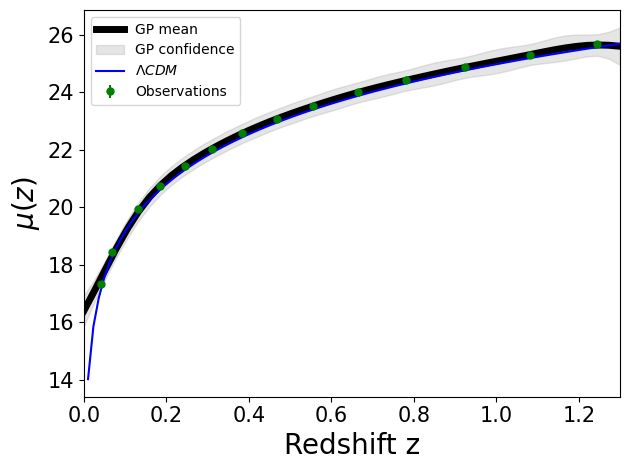

In [26]:
# # The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# # See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Obtain the predictive mean and covariance matrix
    f_preds = model(x_test)
    f_mean_mu = f_preds.mean[:, 0]
    f_mean_err = f_preds.mean[:, 1]
    f_cov = f_preds.covariance_matrix
    # Make predictions by feeding model through likelihood
    observed_pred = likelihood(model(x_test))
#     print(type(observed_pred))
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    lower_mu = lower[:, 0]
    upper_mu = upper[:, 0]
    lower_err = lower[:, 0]
    upper_err = upper[:, 0]
    observed_pred_mean_mu = observed_pred.mean.numpy()[:, 0]
    observed_pred_mean_err = observed_pred.mean.numpy()[:, 1]
#     print(observed_pred.mean.numpy())
    plt.plot(x_test.numpy(), observed_pred_mean_mu-19, color='k', label='GP mean', linewidth=5)
#     # Shade between the lower and upper confidence bounds
    plt.fill_between(x_test.numpy(), lower_mu-19, upper_mu-19, alpha=0.2, label='GP confidence', color='gray')
#     plt.errorbar(x_test.numpy(), observed_pred_mean_mu-19, yerr=observed_pred_mean_err)

plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(df_data['zCMB'], df_data['MU']-19, df_data['errors'], fmt='g.', markersize=10, label='Observations')


plt.xlim(0,1.3)

plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()

In [27]:
np.shape(x_test.numpy()), np.shape(observed_pred_mean_mu), np.shape(observed_pred_mean_err)

((50,), (50,), (50,))

# Single output 1D and cov matrix

In [53]:
class GaussianProcess(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, likelihood):
        super(GaussianProcess, self).__init__(x_train, y_train, likelihood)
        self.mean = gpytorch.means.ConstantMean() # Construct the mean function
#         self.cov = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=2) # Construct the kernel function
#         self.cov = gpytorch.kernels.RBFKernel()
        self.cov = gpytorch.kernels.MaternKernel(nu=1.5, lengthscale=0.01)
#             gpytorch.kernels.SpectralMixtureKernel(num_mixtures=2), num_tasks=2, rank=1
        # Comment the following for RBF Kernel and Matern Kernel
#         self.cov.initialize_from_data(x_train, y_train) # Initialize the hyperparameters from data
        
    def forward(self, x):
        # Evaluate the mean and kernel function at x
        mean_x = self.mean(x)
        cov_x = self.cov(x)
        # Return the multivariate normal distribution using the evaluated mean and kernel function
        return gpytorch.distributions.MultivariateNormal(mean_x, cov_x)        


In [54]:
# Initialize the likelihood and model
# likelihood2 = gpytorch.likelihoods.GaussianLikelihood()
likelihood2 = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(
                                noise=y_torch[:, 1],
                                learn_additional_noise=False)



model2 = GaussianProcess(z_torch, y_torch[:, 0], likelihood2)

In [55]:
# Put the model into training mode
model2.train()
likelihood2.train()

# Use the Adam optimizer, with learning rate set to 0.1
optimizer = torch.optim.Adam(model2.parameters(), lr=0.005)
# Use the negative marginal log-likelihood as the loss function
mll2 = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood2, model2)

# Set the number of training iterations
n_iter = 1000

In [56]:
for i in range(n_iter):
    # Set the gradients from previous iteration to zero
    optimizer.zero_grad()
    # Output from model
    output = model2(z_torch)
    # Compute loss and backprop gradients
#     loss = -mll(output, y_train.reshape(-1,1))
    loss = -mll2(output, y_torch[:, 0].reshape(-1,1)).mean()  # or .sum()
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
    optimizer.step()

Iter 1/1000 - Loss: 102.179
Iter 2/1000 - Loss: 101.988
Iter 3/1000 - Loss: 101.797
Iter 4/1000 - Loss: 101.608
Iter 5/1000 - Loss: 101.420
Iter 6/1000 - Loss: 101.232
Iter 7/1000 - Loss: 101.045
Iter 8/1000 - Loss: 100.860
Iter 9/1000 - Loss: 100.675
Iter 10/1000 - Loss: 100.491
Iter 11/1000 - Loss: 100.308
Iter 12/1000 - Loss: 100.126
Iter 13/1000 - Loss: 99.945
Iter 14/1000 - Loss: 99.765
Iter 15/1000 - Loss: 99.586
Iter 16/1000 - Loss: 99.408
Iter 17/1000 - Loss: 99.231
Iter 18/1000 - Loss: 99.055
Iter 19/1000 - Loss: 98.880
Iter 20/1000 - Loss: 98.706
Iter 21/1000 - Loss: 98.532
Iter 22/1000 - Loss: 98.360
Iter 23/1000 - Loss: 98.189
Iter 24/1000 - Loss: 98.019
Iter 25/1000 - Loss: 97.850
Iter 26/1000 - Loss: 97.682
Iter 27/1000 - Loss: 97.515
Iter 28/1000 - Loss: 97.349
Iter 29/1000 - Loss: 97.183
Iter 30/1000 - Loss: 97.019
Iter 31/1000 - Loss: 96.856
Iter 32/1000 - Loss: 96.694
Iter 33/1000 - Loss: 96.533
Iter 34/1000 - Loss: 96.372
Iter 35/1000 - Loss: 96.213
Iter 36/1000 - Lo

Iter 332/1000 - Loss: 71.687
Iter 333/1000 - Loss: 71.642
Iter 334/1000 - Loss: 71.598
Iter 335/1000 - Loss: 71.553
Iter 336/1000 - Loss: 71.509
Iter 337/1000 - Loss: 71.465
Iter 338/1000 - Loss: 71.420
Iter 339/1000 - Loss: 71.376
Iter 340/1000 - Loss: 71.332
Iter 341/1000 - Loss: 71.289
Iter 342/1000 - Loss: 71.245
Iter 343/1000 - Loss: 71.201
Iter 344/1000 - Loss: 71.158
Iter 345/1000 - Loss: 71.115
Iter 346/1000 - Loss: 71.071
Iter 347/1000 - Loss: 71.028
Iter 348/1000 - Loss: 70.985
Iter 349/1000 - Loss: 70.942
Iter 350/1000 - Loss: 70.899
Iter 351/1000 - Loss: 70.857
Iter 352/1000 - Loss: 70.814
Iter 353/1000 - Loss: 70.772
Iter 354/1000 - Loss: 70.729
Iter 355/1000 - Loss: 70.687
Iter 356/1000 - Loss: 70.645
Iter 357/1000 - Loss: 70.603
Iter 358/1000 - Loss: 70.561
Iter 359/1000 - Loss: 70.519
Iter 360/1000 - Loss: 70.478
Iter 361/1000 - Loss: 70.436
Iter 362/1000 - Loss: 70.394
Iter 363/1000 - Loss: 70.353
Iter 364/1000 - Loss: 70.312
Iter 365/1000 - Loss: 70.271
Iter 366/1000 

Iter 683/1000 - Loss: 60.540
Iter 684/1000 - Loss: 60.517
Iter 685/1000 - Loss: 60.493
Iter 686/1000 - Loss: 60.469
Iter 687/1000 - Loss: 60.445
Iter 688/1000 - Loss: 60.422
Iter 689/1000 - Loss: 60.398
Iter 690/1000 - Loss: 60.374
Iter 691/1000 - Loss: 60.351
Iter 692/1000 - Loss: 60.327
Iter 693/1000 - Loss: 60.304
Iter 694/1000 - Loss: 60.280
Iter 695/1000 - Loss: 60.257
Iter 696/1000 - Loss: 60.233
Iter 697/1000 - Loss: 60.210
Iter 698/1000 - Loss: 60.186
Iter 699/1000 - Loss: 60.163
Iter 700/1000 - Loss: 60.140
Iter 701/1000 - Loss: 60.116
Iter 702/1000 - Loss: 60.093
Iter 703/1000 - Loss: 60.070
Iter 704/1000 - Loss: 60.046
Iter 705/1000 - Loss: 60.023
Iter 706/1000 - Loss: 60.000
Iter 707/1000 - Loss: 59.977
Iter 708/1000 - Loss: 59.954
Iter 709/1000 - Loss: 59.931
Iter 710/1000 - Loss: 59.907
Iter 711/1000 - Loss: 59.884
Iter 712/1000 - Loss: 59.861
Iter 713/1000 - Loss: 59.838
Iter 714/1000 - Loss: 59.815
Iter 715/1000 - Loss: 59.792
Iter 716/1000 - Loss: 59.769
Iter 717/1000 

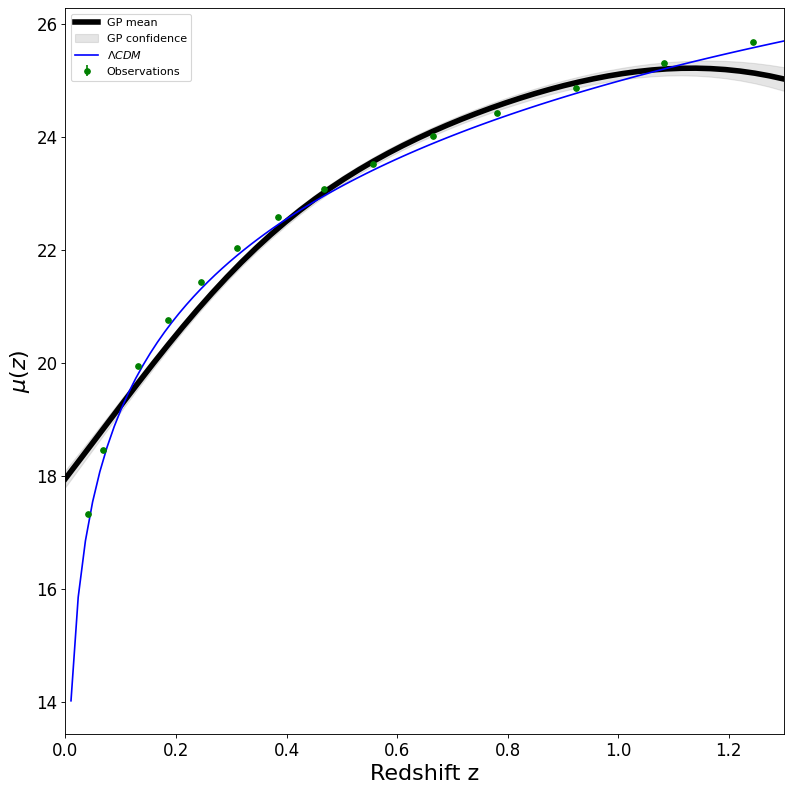

In [57]:
# Plotting
# plt.figure(figsize=(5, 4), dpi=100)
# The test data is 50 equally-spaced points
x_test = torch.linspace(0, 1.3, 50)
# Put the model into evaluation mode
model2.eval()
likelihood2.eval()

fig = plt.figure(figsize=(10, 10), dpi=80)

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Obtain the predictive mean and covariance matrix
    f_preds = model2(x_test)
    f_mean = f_preds.mean
    f_cov = f_preds.covariance_matrix
    # Make predictions by feeding model through likelihood
    observed_pred = likelihood2(model2(x_test))
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    plt.plot(x_test.numpy(), observed_pred.mean.numpy()-19, color='k', label='GP mean', linewidth=5)
    # Shade between the lower and upper confidence bounds
    plt.fill_between(x_test.numpy(), lower.numpy()-19, upper.numpy()-19, alpha=0.2, label='GP confidence', color='gray')


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(df_data['zCMB'], df_data['MU']-19, df_data['errors'], fmt='g.', markersize=10, label='Observations')
# plt.errorbar(x_test, prediction_mc_dropout[:,0]-19, yerr=sigma, markersize=2, fmt='o', 
#              ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
#              label='Synthetic data with $\sigma$')

plt.xlim(0,1.3)

# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()

# zCMB 	MU 	errors